Copyright © 2022 Gurobi Optimization, LLC

# How Much Is Too Much? Avocado Pricing and Supply Using Mathematical Optimization

A [Food Network article](https://www.foodnetwork.com/fn-dish/news/2018/3/avocado-unseats-banana-as-america-s-top-fruit-import-by-value) from March 2017 declared, "Avocado unseats banana as America's top fruit import." This declaration is incomplete and debatable for reasons other than whether  avocado is a fruit. Avocados are expensive.

As a supplier, setting an appropriate avocado price requires a delicate trade-off.
Set it too high and you lose customers. Set it too low and you won't make a profit.
Equipped with good data, the avocado pricing and supply problem is *ripe* with opportunities for demonstrating the power of optimization and data science.

They say when life gives you avocados, make guacamole.
Just like the perfect guacamole needs the right blend of onion, lemon and spices, finding an optimal avocado price needs the right blend of descriptive, predictive and prescriptive analytics.

|<img src="https://github.com/Gurobi/modeling-examples/blob/master/price_optimization/avocado_image_grocery.jpeg?raw=1" width="500" align="center">|
|:--:|
| <b>Avocados: a quintessential corner of a grocery store. Image Credits: [New York Post](https://nypost.com/2022/02/15/us-will-halt-mexico-avocado-imports-as-long-as-necessary/) </b>|


**Goal**: Develop a data science pipeline for pricing and distribution of avocados to maximize revenue.

This notebook walks through a decision-making pipeline that culminates in a mathematical optimization model.
There are three stages:
- First, understand the dataset and infer the relationships between categories such as the sales, price, region, and seasonal trends.
- Second, build a prediction model that predicts the demand for avocados as a function of price, region, year and the seasonality.
- Third, design an optimization problem that sets the optimal price and supply quantity to maximize the net revenue while incorporating costs for wastage and transportation.


## Load the Packages and the Datasets

We use real sales data provided by the [Hass Avocado Board](https://hassavocadoboard.com/) (HAB), whose aim is to "make avocados America’s most popular fruit". This dataset contains consolidated information on several years' worth of market prices and sales of avocados.

We will now load the following packages for analyzing and visualizing the data.

In [1]:
%pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 23.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import sklearn

import numpy as np

The dataset from HAB contains sales data for the years 2019-2022. This data is augmented by a previous download from HAB available on [Kaggle](https://www.kaggle.com/datasets/timmate/avocado-prices-2020) with sales for the years 2015-2018.

Each row in the dataset is the weekly number of avocados sold and the weekly average price of an avocado categorized by region and type of avocado. There are two types of avocados: conventional and organic. In this notebook, we will only consider the conventional avocados.
There are eight large regions, namely the Great Lakes, Midsouth, North East, Northern New England, South Central, South East, West and Plains.

Now, load the data and store into a Pandas dataframe.

In [3]:
# Carga un archivo CSV de precios de palta desde una URL directamente en un dataframe de Pandas llamado avocado.
avocado = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/price_optimization/HABdata_2019_2022.csv') # dataset downloaded directly from HAB
# Carga otro archivo CSV de precios de palta desde otra URL en otro dataframe de Pandas llamado avocado_old.
avocado_old = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/price_optimization/kaggledata_till2018.csv') # dataset downloaded from Kaggle
# Combina los dos dataframes de Pandas (avocado y avocado_old) en uno solo llamado avocado, mediante la función append(). Se utiliza el parámetro
# ignore_index=True para evitar conflictos de índice, es decir, reindexar las filas de forma consecutiva en el nuevo dataframe.
avocado = avocado.append(avocado_old, ignore_index=True)
# Muestra el dataframe combinado resultante, que contiene los datos de ambos archivos CSV cargados.

avocado

<ipython-input-3-f8855d8f8ea4>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  avocado = avocado.append(avocado_old, ignore_index=True)


,region,date,type,price,units_sold
0,Great_Lakes,1/7/19 0:00,Conventional,1.106743,3812441.96
1,Great_Lakes,1/7/19 0:00,Organic,1.371280,275987.52
2,Great_Lakes,1/13/19 0:00,Conventional,1.063457,3843318.68
3,Great_Lakes,1/13/19 0:00,Organic,1.493384,244991.95
4,Great_Lakes,1/20/19 0:00,Conventional,1.049931,4587957.69
...,...,...,...,...,...
6799,West,11/18/18,Organic,1.610000,334096.14
6800,West,11/25/18,Conventional,1.240000,3260102.17
6801,West,11/25/18,Organic,1.730000,268362.34
6802,West,12/2/18,Conventional,1.200000,4594863.86


## Prepare the Dataset

We will now prepare the data for making sales predictions. Add new columns to the dataframe for the year and seasonality. Let each year from 2015 through 2022 be given an index from 0 through 7 in the increasing order of the year. We will define the peak season to be the months of February through July. These months are set based on visual inspection of the trends, but you can try setting other months.

In [4]:
# Add the index for each year from 2015 through 2022

# Convierte la columna "date" del dataframe "avocado" en formato de fecha y hora utilizando la función "to_datetime" de la librería Pandas.
avocado['date'] = pd.to_datetime(avocado['date'])
# Extrae el año de la fecha en la columna "date" del dataframe "avocado" y lo guarda en una nueva columna llamada "year".
avocado['year'] = pd.DatetimeIndex(avocado['date']).year
# Crea una nueva columna llamada "year_index" en el dataframe "avocado" que indica el índice del año (de 0 a 7) a partir de 2015.
# Por ejemplo, el año 2015 se asigna un índice de 0, el año 2016 se asigna un índice de 1, y así sucesivamente.
avocado['year_index'] = avocado['year'] - 2015
# Ordena el dataframe "avocado" por fecha en orden ascendente.
avocado = avocado.sort_values(by='date')

# Define the peak season

# crea una nueva columna llamada "month" en el conjunto de datos "avocado", que contiene el mes correspondiente a cada registro
# de fecha en la columna "date".
avocado['month'] = pd.DatetimeIndex(avocado['date']).month
# crea un rango de números que corresponde a los meses considerados como temporada alta de aguacates. En este caso, los meses son febrero (2) a julio (7).
peak_months = range(2,8)        # <--------- Set the months for the "peak season"
# define una función llamada "peak_season" que toma una fila del conjunto de datos "avocado" como entrada.
def peak_season(row):
  # la función "peak_season" devuelve 1 si el mes correspondiente a la fila de entrada se encuentra dentro del rango
  # de meses de temporada alta de aguacates, de lo contrario devuelve 0.
    return 1 if int(row['month']) in peak_months else 0
# crea una nueva columna llamada "peak" en el conjunto de datos "avocado" que contiene el valor de la función "peak_season"
# para cada fila del conjunto de datos "avocado". Se utiliza la función "apply" para aplicar la función "peak_season" a cada fila del conjunto
# de datos "avocado", y el argumento "axis=1" indica que se debe aplicar la función a cada fila (en contraposición a aplicarla a cada columna).
avocado['peak'] = avocado.apply(lambda row: peak_season(row), axis=1)

# Scale the number of avocados to millions
# convierte la columna "units_sold" del dataframe "avocado" de unidades a millones.
avocado['units_sold'] = avocado['units_sold']/1000000

# Select only conventional avocados
# selecciona solamente las filas en el dataframe "avocado" donde el tipo de aguacate es "Conventional".
avocado = avocado[avocado['type'] == 'Conventional']

# selecciona solamente las columnas relevantes para el análisis y reinicia el índice del dataframe "avocado" para que comience desde 0.
avocado = avocado[['date','units_sold','price','region','year','month','year_index','peak']].reset_index(drop = True)

avocado

,date,units_sold,price,region,year,month,year_index,peak
0,2015-01-04,3.382800,1.020000,Great_Lakes,2015,1,0,0
1,2015-01-04,2.578275,1.100000,Midsouth,2015,1,0,0
2,2015-01-04,5.794411,0.890000,West,2015,1,0,0
3,2015-01-04,3.204112,0.980000,Southeast,2015,1,0,0
4,2015-01-04,0.321824,1.050000,Northern_New_England,2015,1,0,0
...,...,...,...,...,...,...,...,...
3397,2022-05-15,4.150433,1.269883,SouthCentral,2022,5,7,1
3398,2022-05-15,4.668815,1.644873,Northeast,2022,5,7,1
3399,2022-05-15,32.745321,1.527357,Total_US,2022,5,7,1
3400,2022-05-15,3.542902,1.514583,Midsouth,2022,5,7,1


## Part 1: Observe Trends in the Data

Now, we will infer sales trends in time and seasonality. For simplicity, let's proceed with data from the United States as a whole.

In [5]:
# crea un nuevo dataframe llamado df_Total_US que contiene sólo los datos de las ventas de aguacates en la región de los Estados Unidos.
df_Total_US = avocado[avocado['region']=='Total_US']

df_Total_US

,date,units_sold,price,region,year,month,year_index,peak
5,2015-01-04,31.324278,0.950000,Total_US,2015,1,0,0
14,2015-01-11,29.063543,1.010000,Total_US,2015,1,0,0
21,2015-01-18,29.043459,1.030000,Total_US,2015,1,0,0
34,2015-01-25,28.470311,1.040000,Total_US,2015,1,0,0
44,2015-02-01,44.655462,0.890000,Total_US,2015,2,0,1
...,...,...,...,...,...,...,...,...
3357,2022-04-17,35.333545,1.456068,Total_US,2022,4,7,1
3374,2022-04-24,33.297205,1.471539,Total_US,2022,4,7,1
3378,2022-05-01,41.009154,1.380105,Total_US,2022,5,7,1
3392,2022-05-08,38.280200,1.438612,Total_US,2022,5,7,1


### Sales Over the Years

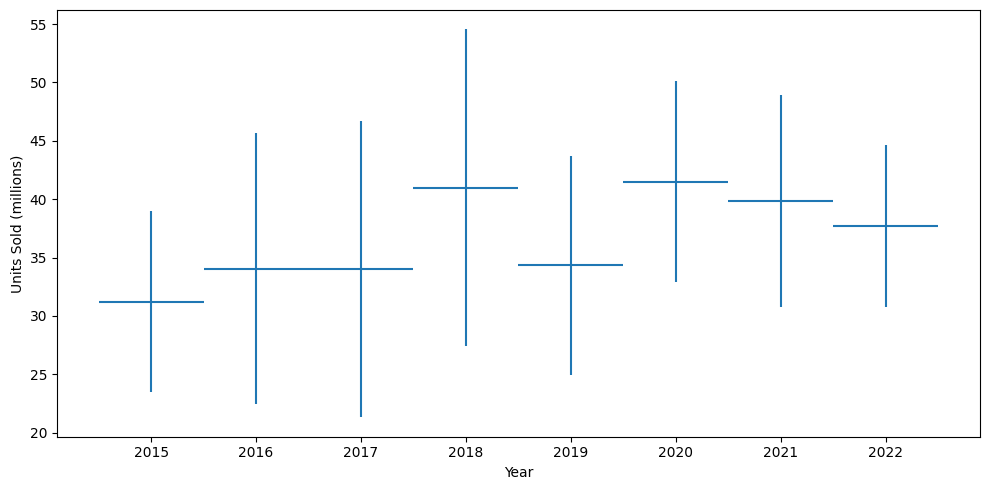

In [6]:
# crea una figura y un eje para mostrar el gráfico con una sola fila y columna, con un tamaño de 10 por 5 pulgadas.
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# agrupa los datos de df_Total_US por año y calcula la media de las unidades vendidas para cada año, almacenándolas en una variable llamada mean.
mean = df_Total_US.groupby('year')['units_sold'].mean()
# agrupa los datos de df_Total_US por año y calcula la desviación estándar de las unidades vendidas para cada año, almacenándolas en
# una variable llamada std.
std  = df_Total_US.groupby('year')['units_sold'].std()
# traza un gráfico de error en el eje axes utilizando los valores medios de ventas por año (mean), especificando el índice de cada año
# como la posición en el eje X (mean.index), y la desviación estándar (std) como el tamaño de los errores. El parámetro xerr=0.5
# establece la longitud de los errores horizontales en 0.5, y yerr=2*std establece la longitud de los errores verticales como el
# doble de la desviación estándar. El parámetro linestyle='' elimina la línea entre los puntos de datos.
axes.errorbar(mean.index, mean, xerr=0.5, yerr=2*std, linestyle='')
# establece la etiqueta del eje Y como "Unidades vendidas (millones)".
axes.set_ylabel('Units Sold (millions)')
# establece la etiqueta del eje X como "Año".
axes.set_xlabel('Year')

# ajusta el tamaño de la figura para que todos los elementos queden dentro del área de trazado.
fig.tight_layout()

We can see that the sales generally increased over the years, albeit marginally. The dip in 2019 is the effect of the well-documented [2019 avocado shortage](https://abc7news.com/avocado-shortage-season-prices/5389855/) that led to avocados [nearly doubling in price.](https://abc7news.com/avocado-shortage-season-prices/5389855/)

### Seasonality

We will now see the sales trends within a year.

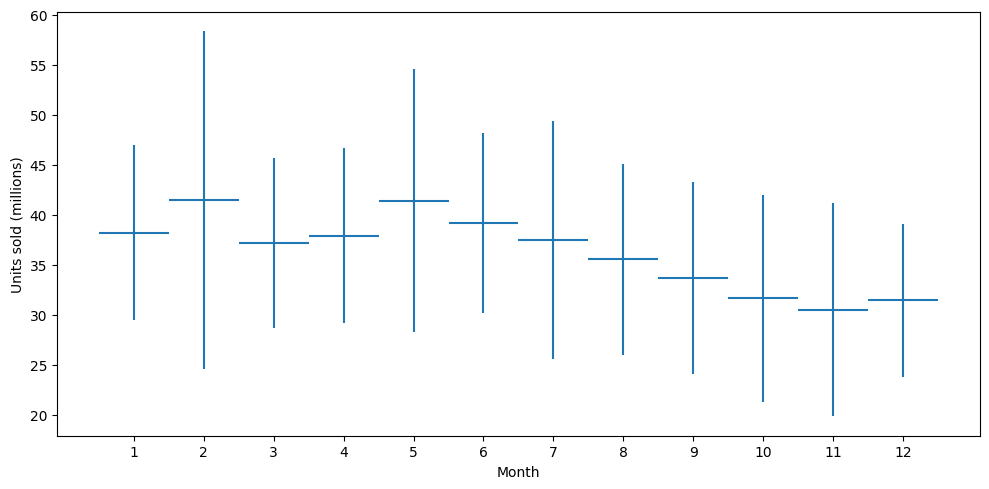

In [7]:
# crea una figura y un conjunto de ejes utilizando la función subplots() de Matplotlib. Se le asigna a fig el objeto de
# la figura y a axes el objeto del conjunto de ejes. El argumento nrows=1 especifica que la figura tendrá una sola fila de ejes,
# mientras que ncols=1 especifica que la figura tendrá una sola columna de ejes. El argumento figsize=(10,5) especifica el tamaño de la figura en pulgadas.
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# calcula la media de las unidades vendidas agrupadas por mes en el DataFrame df_Total_US. El resultado se almacena en la variable mean.
mean = df_Total_US.groupby('month')['units_sold'].mean()
# calcula la desviación estándar de las unidades vendidas agrupadas por mes en el DataFrame df_Total_US. El resultado se almacena en la variable std.
std  = df_Total_US.groupby('month')['units_sold'].std()

# crea un gráfico de barras con barras de error utilizando la función errorbar() de Matplotlib en los ejes axes. El argumento
# mean.index especifica la ubicación en el eje x de cada barra, mean especifica la altura de cada barra, xerr=0.5 especifica la longitud
# de las barras de error horizontales (en este caso, todas las barras de error tienen la misma longitud de 0.5), yerr=2*std especifica
# la longitud de las barras de error verticales (en este caso, las barras de error son dos veces la desviación estándar), y linestyle=''
# especifica que no se dibuje una línea de conexión entre la barra y la barra de error.
axes.errorbar(mean.index, mean, xerr=0.5, yerr=2*std, linestyle='')
# establece la etiqueta del eje y como "Unidades vendidas (millones)".
axes.set_ylabel('Units Sold (millions)')
# establece la etiqueta del eje x como "Mes".
axes.set_xlabel('Month')

# ajusta automáticamente el diseño de la figura para que no haya superposición entre los elementos.
fig.tight_layout()

# establece la etiqueta del eje x como "Mes".
plt.xlabel('Month')
#  establece las marcas del eje x en los valores de 1 a 12.
axes.set_xticks(range(1,13))
# establece la etiqueta del eje y como "Unidades vendidas (millones)".
plt.ylabel('Units sold (millions)')
# muestra la figura.
plt.show()

We see a Super Bowl peak in February and a Cinco de Mayo peak in May.

### Correlations

Now, we will see how the variables are correlated with each other.
The end goal is to predict sales given the price of an avocado, year and seasonality (peak or not).

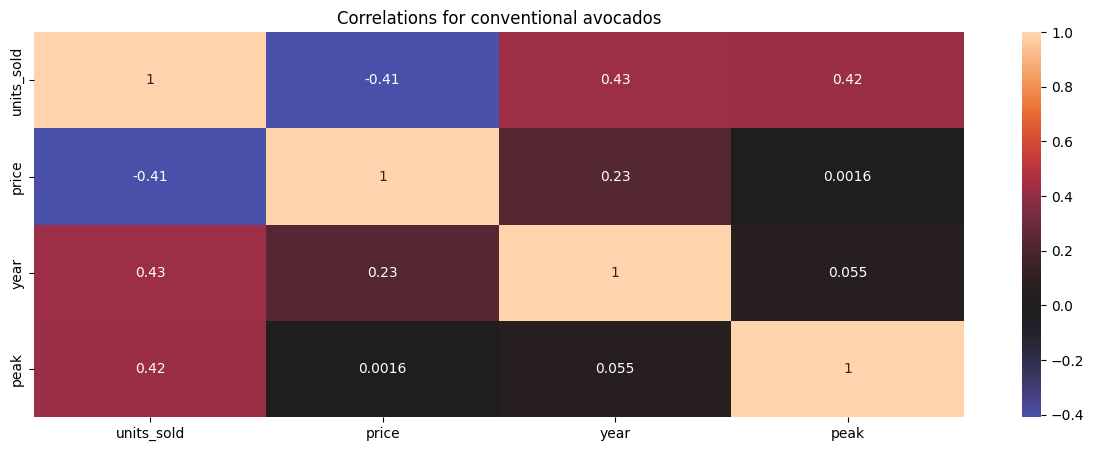

In [8]:
# crea una figura y un conjunto de ejes utilizando la función subplots() de Matplotlib. Se le asigna a fig el objeto de la figura
# y a axes el objeto del conjunto de ejes. El argumento nrows=1 especifica que la figura tendrá una sola fila de ejes, mientras
# que ncols=1 especifica que la figura tendrá una sola columna de ejes. El argumento figsize=(15,5) especifica el tamaño de la figura en pulgadas.
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
# crea un mapa de calor utilizando la función heatmap() de Seaborn. Se utiliza el DataFrame df_Total_US y se seleccionan
# las columnas 'units_sold', 'price', 'year' y 'peak'. El método corr() calcula la correlación entre estas columnas
# y el resultado se visualiza en el mapa de calor. El argumento annot=True muestra los valores de correlación en el mapa de calor.
# El argumento center=0 establece el valor central del mapa de calor en 0. El argumento ax=axes indica que el mapa de calor
# se debe dibujar en los ejes axes creados anteriormente.
sns.heatmap(df_Total_US[['units_sold', 'price', 'year', 'peak']].corr(),annot=True, center=0,ax=axes)

# establece el título de los ejes como "Correlaciones para aguacates convencionales".
axes.set_title('Correlations for conventional avocados')
# muestra la figura.
plt.show()

As expected, the sales quantity has a negative correlation with the price per avocado. The sales quantity has a positive correlation with the year and season being a peak season.

### Regions

Finally, we will see how the sales differ among the different regions. This will determine the number of avocados that we want to supply to each region.

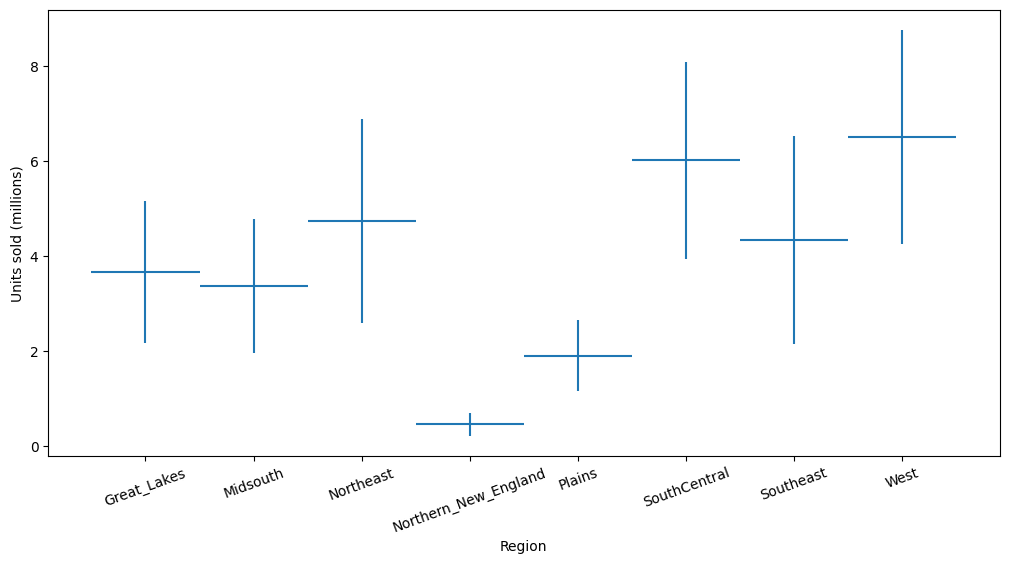

In [9]:
# esta línea crea un objeto de figura fig y un objeto de ejes axes para un gráfico con una sola fila y
# una sola columna de subgráficos, y establece el tamaño de la figura en (10, 5).
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

#  esta línea define una lista de las regiones para las que queremos ver los datos.
regions = ['Great_Lakes','Midsouth','Northeast','Northern_New_England','SouthCentral','Southeast','West','Plains']
# esta línea crea un nuevo dataframe df que contiene solo las filas que pertenecen a las regiones definidas en la lista regions.
df = avocado[avocado.region.isin(regions)]

# esta línea agrupa el dataframe df por región y calcula la media del número de unidades vendidas para cada región.
mean = df.groupby('region')['units_sold'].mean()
# esta línea hace lo mismo que la anterior pero calcula la desviación estándar en lugar de la media.
std  = df.groupby('region')['units_sold'].std()


# esta línea traza un gráfico de barras con barras de error para cada región, utilizando los valores de mean y std para el número de unidades vendidas.
# range(len(mean)) se utiliza para establecer las posiciones de las barras en el gráfico.
axes.errorbar(range(len(mean)), mean, xerr=0.5, yerr=2*std, linestyle='')

# esta línea ajusta automáticamente el espaciado del gráfico para que no haya superposición entre los subgráficos y los bordes de la figura.
fig.tight_layout()

# esta línea establece una etiqueta para el eje x del gráfico.
plt.xlabel('Region')
# esta línea establece las etiquetas de las regiones en el eje x del gráfico, utilizando los nombres de las regiones en la lista regions.
plt.xticks(range(len(mean)), pd.DataFrame(mean)['units_sold'].index,rotation=20)
# esta línea establece una etiqueta para el eje y del gráfico.
plt.ylabel('Units sold (millions)')
# esta línea muestra el gráfico en la pantalla.
plt.show()

Clearly, west-coasters love avocados.

## Part II: Predict the Sales

The trends observed in Part I motivate us to construct a prediction model for sales using the independent variables- price, year, region and seasonality.
Henceforth, the sales quantity will be referred to as the *predicted demand*.

Let us now construct a linear regressor for the demand.
Note that the region is a categorical variable.
The linear regressor can be mathematically expressed as:

$$demand = \beta_0 + \beta_1 * price + \sum\limits_{region} \beta^{region}_3 * \mathbb{1}(region)  +  \beta_4 w_{year}*year +  \beta_5  * \mathbb{1}(peak).$$

Here, the $\beta$ values are weights (or "co-efficients") that have to be learned from the data.
Note that the notation $\mathbb{1}(region)$ is an indicator function that takes the value $1$ for each region in the summation. The value of $\mathbb{1}(peak)$ is $1$ if we consider the peak season.

To validate the regression model, we will randomly split the dataset into $80\%$ training and $20\%$ testing data and learn the weights using sklearns.

In [10]:
# Importar las librerías necesarias
import statsmodels.api as sm # Para ajustar el modelo de regresión lineal
import statsmodels.formula.api as smf # Para especificar la fórmula del modelo
from sklearn.model_selection import train_test_split # Para dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.metrics import r2_score # Para calcular el coeficiente de determinación (R^2) del modelo

#np.log()para transformar variables
df['log_demand'] = np.log(df['units_sold'])
df['log_price'] = np.log(df['price'])

# Dividir los datos en conjuntos de entrenamiento y prueba
train, test = train_test_split(df, train_size=0.8, random_state=1)

# Crear dataframes de pandas para los datos de entrenamiento y prueba
df_train = pd.DataFrame(train, columns=df.columns)
df_test = pd.DataFrame(test, columns=df.columns)

# Especificar la fórmula del modelo de regresión lineal
formula = 'log_demand ~ log_price * C(region) + year_index + peak'

# Ajustar el modelo utilizando los datos de entrenamiento
mod = smf.ols(formula, data=df_train) # Crear el modelo utilizando la fórmula y los datos de entrenamiento
result = mod.fit() # Ajustar el modelo utilizando los datos de entrenamiento

# Imprimir un resumen de los resultados del modelo
print(result.summary()) # Imprimir un resumen de los resultados del modelo ajustado

# Calcular el R^2 del modelo en los datos de prueba
y_true = df_test['log_demand'] # Guardar los valores reales de la variable dependiente en los datos de prueba
y_pred = result.predict(df_test) # Predecir los valores de la variable dependiente utilizando el modelo ajustado y los datos de prueba
r2 = r2_score(y_true, y_pred) # Calcular el R^2 utilizando los valores reales y predichos de la variable dependiente

# Imprimir el R^2 del modelo en los datos de prueba
print('El R^2 del modelo en los datos de prueba es:', r2)

                            OLS Regression Results                            
Dep. Variable:             log_demand   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     5110.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        11:40:58   Log-Likelihood:                 1379.2
No. Observations:                2419   AIC:                            -2722.
Df Residuals:                    2401   BIC:                            -2618.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

<ipython-input-10-ff66002d22f4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_demand'] = np.log(df['units_sold'])
<ipython-input-10-ff66002d22f4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_price'] = np.log(df['price'])


In [11]:
# Especificar la fórmula del modelo de regresión lineal
formula = 'log_demand ~ log_price * C(region) + year_index + peak'

# Ajustar el modelo utilizando todos los datos
mod_full = smf.ols(formula, data=df)
result_full = mod_full.fit()

# Predecir los valores de la variable dependiente utilizando el modelo ajustado y todos los datos
y_true_full = df['log_demand'] # Guardar los valores reales de la variable dependiente en todos los datos
y_pred_full = result_full.predict(df) # Predecir los valores de la variable dependiente utilizando el modelo ajustado y todos los datos

# Imprimir el R^2 del modelo en todos los datos
r2_full = r2_score(y_true_full, y_pred_full) # Calcular el R^2 utilizando los valores reales y predichos de la variable dependiente en todos los datos
print("El coeficiente de determinación (R^2) del modelo en todos los datos es:", r2_full)

# Obtener los coeficientes del modelo y almacenarlos en un diccionario
coef_dict = result_full.params.to_dict()
# Establecer el coeficiente de la región Great_Lakes en cero
coef_dict['C(region)[T.Great_Lakes]'] = 0
coef_dict['log_price:C(region)[T.Great_Lakes]'] = 0


El coeficiente de determinación (R^2) del modelo en todos los datos es: 0.9727898326085627


## Part III: Optimize for Price and Supply of Avocados

Knowing how the price of an avocado affects the demand, how can we set the optimal avocado price?
We don't want to set the price too high, since that could drive demand and sales down. At the same time, setting the price too low could be sub-optimal when maximizing revenue. So what is the sweet spot?

On the distribution logistics, we want to make sure that there are enough avocados across the regions. We can address these considerations in a mathematical optimization model.
An optimization model finds the **best solution** according to an **objective function** such that the solution satisfies a set of **constraints**.
Here, a solution is expressed as a vector of real values or integer values called **decision variables**.
Constraints are a set of equations or inequalities written as a function of the decision variables.

At the start of each week, assume that the total number of available products is finite. This quantity needs to be distributed to the various regions while maximizing net revenue. So there are two key decisions - the price of an avocado in each region, and the number of avocados allocated to each region.

Let us now define some input parameters and notations used for creating the model. The subscript $r$ will be used to denote each region.

### Input Parameters
- $R$: set of regions,
- $d(p,r)$: predicted demand in region $r\in R$ when the avocado per product is $p$,
- $B$: available avocados to be distributed across the regions,
- $c_{waste}$: cost ($\$$) per wasted avocado,
- $c^r_{transport}$: cost ($\$$) of transporting a avocado to region $r \in R$,
- $a^r_{min},a^r_{max}$: minimum and maximum price ($\$$) per avocado for reigon $r \in R$,
- $b^r_{min},b^r_{max}$: minimum and maximum number of avocados allocated to region $r \in R$,

The following code loads the Gurobi python package and initiates the optimization model.
The value of $B$ is set to $30$ million avocados, which is close to the average weekly supply value from the data.
For illustration, let us consider the peak season of 2021.
The cost of wasting an avocado is set to $\$0.10$.
The cost of transporting an avocado ranges between $\$0.10$ to $\$0.50$ based on each region's distance from the southern border, where the [majority of avocado supply comes from](https://www.britannica.com/plant/avocado).
Further, we can set the price of an avocado to not exceed $\$ 2$ apiece.

In [12]:
import gurobipy as gp
from gurobipy import GRB

# Crear un modelo llamado "Avocado_Price_Allocation"
m = gp.Model("Avocado_Price_Allocation")

# Definir los sets y parámetros
R = regions   # set de todas las regiones
B = 30  # cantidad total de aguacates disponibles
peak_or_not = 1 # 1 si es temporada alta, 0 si no lo es
year = 2022
c_waste = 0.1 # costo ($) de desperdiciar un aguacate
c_transport = {'Great_Lakes': .3,'Midsouth':.1,'Northeast':.4,'Northern_New_England':.5,'SouthCentral':.3,'Southeast':.2,'West':.2,'Plains':.2}
# costo de transportar un aguacate por región

# Obtener los límites inferior y superior de precio y número de productos a ser almacenados
a_min = {r: 0.01 for r in R} # precio mínimo del aguacate en cada región
a_max = {r: 2 for r in R} # precio máximo del aguacate en cada región
b_min = dict(df.groupby('region')['units_sold'].min())  # número mínimo de aguacates a ser distribuidos en cada región
b_max = dict(df.groupby('region')['units_sold'].max())   # número máximo de aguacates a ser distribuidos en cada región


Restricted license - for non-production use only - expires 2024-10-28


### Decision Variables

Let us now define the decision variables.
In our model, we want to store the price and number of avocados allocated to each region. We also want variables that track how many avocados are predicted to be sold and how many are predicted to be wasted.
The following notation is used to model these decision variables, indexed for each region $r$.

$p_r$: the price of an avocado ($\$$) in region $r$,

$x_r$: the number of products avocados supplied to region $r$,

$s_r = \min \{x_r,d_r(p_r)\}$: the predicted number of avocados sold in region $r$,

$w_r = x_r - s_r$: the predicted number of avocados wasted in region $r$

We will now add the variables to the Gurobi model.

In [13]:
# Crear variables de decisión para el precio en cada región "p", la cantidad suministrada en cada región "x",
# la cantidad de aguacates vendidos en cada región "s" y el desperdicio en cada región "w"
p = m.addVars(R,name="p",lb=a_min, ub=a_max)   # price of avocados in each region
x = m.addVars(R,name="x",lb=b_min,ub=b_max)  # quantity supplied to each region
s = m.addVars(R,name="s",lb=0)   # predicted amount of sales in each region for the given price
w = m.addVars(R,name="w",lb=0)   # excess wasteage in each region

In [14]:
# Crear una nueva variable para el logaritmo de p
log_p = m.addVars(R, name="log_p", lb={r: np.log(a_min[r]) for r in R}, ub={r: np.log(a_max[r]) for r in R})

# Agregar la restricción de logaritmo para cada variable p[r]
for r in R:
    m.addGenConstrLog(p[r], log_p[r])


In [15]:
# Calcular la demanda utilizando el modelo ajustado y las variables transformadas
d = m.addVars(R, name="d")

for r in R:
    # Calcular la parte lineal de la ecuación
    parte_lineal = coef_dict['Intercept'] + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not
    # Añadir la restricción al modelo
    parte_lineal += coef_dict['log_price']*log_p[r] + coef_dict['log_price:C(region)[T.%s]'%r]*log_p[r]
    m.addConstr(d[r] == parte_lineal)

# Crear una nueva variable para el resultado de la exponencial
exp_d = m.addVars(R, name="exp_d")

# Agregar la restricción de función exponencial para cada variable d[r]
for r in R:
    m.addGenConstrExp(d[r], exp_d[r])


In [16]:
for r in R:
    print(exp_d[r])

<gurobi.Var *Awaiting Model Update*>
<gurobi.Var *Awaiting Model Update*>
<gurobi.Var *Awaiting Model Update*>
<gurobi.Var *Awaiting Model Update*>
<gurobi.Var *Awaiting Model Update*>
<gurobi.Var *Awaiting Model Update*>
<gurobi.Var *Awaiting Model Update*>
<gurobi.Var *Awaiting Model Update*>


Now, let's create an expression for the predicted demand in each region as a function of price. Note that apart from the price, none of the other parameters in this prediction function (such as region, year and seasonality) are decision variables, and hence can be treated as constants.

### Set the Objective

Next, we will define the objective function: we want to maximizing the **net revenue**. The revenue from sales in each region is calculated by the price of an avocado in that region multiplied by the quantity sold there. There are two types of costs incurred: the wastage costs for excess unsold avocados and the cost of transporting the avocados to the different regions.

The net revenue is the sales revenue subtracted by the total costs incurred. We assume that the purchase costs are fixed and are not incorporated in this model.

Using the defined decision variables, the objective can be written as follows.

\begin{align}
\textrm{maximize} &  \sum_{r}  (p_r * s_r - c_{waste} * w_r - c^r_{transport} * x_r)&
\end{align}

Let us now add the objective function to the model.

In [17]:
m.setObjective(sum(p[r]*s[r] - c_waste*w[r] - c_transport[r]*x[r] for r in R))
m.ModelSense = GRB.MAXIMIZE

### Add the Supply Constraint

We now introduce the constraints. The first constraint is to make sure that the total number of avocados supplied is equal to $B$, which can be mathematically expressed as follows.

\begin{align*}
\sum_{r} x_r &= B
\end{align*}

The following code adds this constraint to the model.

In [18]:
#agrega una restricción a la optimización matemática. En este caso, asegura que la suma de los productos suministrados
# a cada región sea igual a la cantidad total de aguacates disponibles B.
m.addConstr(sum(x[r] for r in R) == B)
#actualiza el modelo matemático con la nueva restricción agregada.
m.update()

### Add Constraints That Define Sales Quantity

Next, we should define the predicted sales quantity in each region.
We can assume that if we supply more than the predicted demand, we sell exactly the predicted demand.
Otherwise, we sell exactly the allocated amount.
Hence, the predicted sales quantity is the minimum of the allocated quantity and the predicted demand, i.e., $s_r = \min \{x_r,d_r(p_r)\}$.
This relationship can be modeled by the following two constraints for each region $r$.

\begin{align*}
s_r &\leq x_r  \\
s_r &\leq d(p_r,r)  
\end{align*}

These constraints will ensure that the sales quantity $s_r$ in region $r$ is  greater than neither the allocated quantity nor the predicted demand. Note that the maximization objective function tries to maximize the revenue from sales, and therefore the optimizer will maximize the predicted sales quantity. This is assuming that the surplus and transportation costs are less than the sales price per avocado. Hence, these constraints along with the objective will ensure that the sales are equal to the minimum of supply and predicted demand.

Let us now add these constraints to the model.

In [19]:
m.addConstrs((s[r] <= x[r] for r in R))
m.addConstrs((s[r] <= exp_d[r] for r in R))
m.update()

### Add the Wastage Constraints

Finally, we should define the predicted wastage in each region, given by the supplied quantity that is not predicted to be sold. We can express this mathematically for each region $r$.

\begin{align*}
w_r &= x_r - s_r
\end{align*}

We can add these constraints to the model.

In [20]:
m.addConstrs((w[r] == x[r]-s[r] for r in R))
m.update()

### Fire Up the Solver

We have added the decision variables, objective function, and the constraints to the model.
The model is ready to be solved.
Before we do so, we should let the solver know what type of model this is.
The default setting assumes that the objective and the constraints are linear functions of the variables.

In our model, the objective is **quadratic** since we take the product of price and the predicted sales, both of which are variables.
Maximizing a quadratic term is said to be **non-convex**, and we specify this using a Gurobi parameter value to be $2$.
See [here](https://www.gurobi.com/documentation/9.5/refman/nonconvex.html) for more details.

In [ ]:
#establece un parámetro en el modelo que especifica que la función objetivo es no convexa, es decir, que contiene términos cuadráticos.
m.Params.NonConvex = 2
#resuelve el modelo que se ha construido, es decir, encuentra los valores de las variables de decisión (en este caso, los precios y las cantidades de paltas
# asignadas a cada región) que maximizan la función objetivo, teniendo en cuenta las restricciones definidas. El resultado de la optimización se almacena en el objeto m.
m.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 33 rows, 56 columns and 80 nonzeros
Model fingerprint: 0x625e0d73
Model has 8 quadratic objective terms
Model has 16 general constraints
Variable types: 56 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [6e-01, 1e+00]
  Objective range  [1e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e-02, 1e+01]
  RHS range        [4e-01, 3e+01]
Presolve added 30 rows and 2605 columns
Presolve time: 0.02s
Presolved: 80 rows, 2670 columns, 7757 nonzeros
Presolved model has 16 SOS constraint(s)
Presolved model has 8 bilinear constraint(s)
Variable types: 2670 continuous, 0 integer (0 binary)

Root relaxation: objective 5.317907e+01, 75 iterations, 0.00 seconds (0.00 work units)

   

The solver solved the optimization problem in less than a second.
Let us now analyze the optimal solution by storing it in a Pandas dataframe.

In [ ]:
# Crear un DataFrame vacío para almacenar la solución
solution = pd.DataFrame()

# Agregar una columna para las regiones
solution['Region'] = R

# Agregar una columna para el precio de las paltas en cada región
#solution['price'] = [p[r].X for r in R]
solution['Price'] = [(p[r].X) for r in R]

# Agregar una columna para la cantidad de paltas asignadas a cada región
solution['Allocated'] = [round(x[r].X,8) for r in R]

# Agregar una columna para la cantidad de paltas vendidas en cada región
solution['Sold'] = [round(s[r].X,8) for r in R]

# Agregar una columna para la cantidad de paltas desperdiciadas en cada región
solution['Wasted'] = [round(w[r].X,8) for r in R]

# Agregar una columna para la demanda predicha en cada región
solution['Pred_demand'] = [exp_d[r].getValue() for r in R]


# Obtener el valor óptimo de la función objetivo
opt_revenue = m.ObjVal

# Imprimir el valor óptimo de la función objetivo
print("\n The optimal net revenue: $%f million"%opt_revenue)

# Mostrar la solución
solution


Let us now visualize a scatter plot between the price and the number of avocados sold (in millions) for the eight regions.

In [ ]:
#Crear una figura y un conjunto de ejes:
fig, ax = plt.subplots(1,1)
#Crear un gráfico de dispersión para mostrar la cantidad de paltas vendidas por región en función del precio
plot_sol = sns.scatterplot(data=solution,x='Price',y='Sold',hue='Region',s=100)
#Crear un gráfico de dispersión para mostrar la cantidad de paltas desperdiciadas por región en función del precio:
plot_waste = sns.scatterplot(data=solution,x='Price',y='Wasted',marker='x',hue='Region',s=100,legend = False)

#Añadir la leyenda al gráfico de dispersión para la cantidad de paltas vendidas:
plot_sol.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
#Añadir la leyenda al gráfico de dispersión para la cantidad de paltas desperdiciadas:
plot_waste.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
#Limitar el eje y del gráfico de dispersión para la cantidad de paltas vendidas:
plt.ylim(0, 5)
#Limitar el eje x del gráfico de dispersión para el precio:
plt.xlim(1, 2.2)
#Establecer el nombre del eje x:
ax.set_xlabel('Price per avocado ($)')
#Establecer el nombre del eje y:
ax.set_ylabel('Number of avocados sold (millions)')
#Mostrar el gráfico:
plt.show()
#Imprimir una leyenda que indique que los círculos representan la cantidad de paltas vendidas y las marcas cruzadas representan la cantidad de paltas desperdiciadas:
print("The circles represent sales quantity and the cross markers represent the wasted quantity.")

Copyright © 2022 Gurobi Optimization, LLC